In [1]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms,datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

2024-05-04 09:42:09.182402: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 09:42:09.210286: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 09:42:09.491167: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 09:42:10.736391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 09:42:16.153051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [22]:
# Define the paths to the dataset folders
train_dir = 'raw/train'
test_dir = 'raw/test'
val_dir = 'raw/val'

# Define transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create datasets for train, test, and val
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

train_dataset = ConcatDataset([train_data, val_data])

# Create DataLoaders for train, test, and val
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names=['Cat', 'Dog']

for img, label in train_loader:
    print(img.size())
    break


torch.Size([32, 3, 64, 64])


In [27]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Define transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.255], std = [1/0.229, 1/0.224, 1/0.255])
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])


# Initialize the model
model = CNN(num_classes=len(train_data.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):  # Train for 10 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataset)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {correct / total * 100:.2f}%")

Epoch 1, Loss: 0.434923471819143
Epoch 2, Loss: 0.3190106982799275
Epoch 3, Loss: 0.2933203461279299
Epoch 4, Loss: 0.28867909118139895
Epoch 5, Loss: 0.2814788583588694
Epoch 6, Loss: 0.27956724125036425
Epoch 7, Loss: 0.2774038530974024
Epoch 8, Loss: 0.27690985892543224
Epoch 9, Loss: 0.27325379200894667
Epoch 10, Loss: 0.27344132245741554
Test Accuracy: 97.93%


In [24]:

def saliency(img, model):
    '''
        Compute the saliency map of an input image with respect to the model's prediction.

        Args:
        - img (PIL.Image): Input image.
        - model (torch.nn.Module): Pre-trained neural network model.

        Returns:
        - None: Display the original image and its corresponding saliency map.
    '''

    # Disable gradient calculation for model parameters since we're not training
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model to evaluation mode
    model.eval()

    # Transform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    # Set requires_grad to True for input to compute gradients 
    input.requires_grad = True

    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    print(class_names[indices.item()])

    # Backward pass to get gradients of predicted class score w.r.t. input image
    score.backward()

    # Get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    # Normalize saliency map to [0, 1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    # Apply inverse transform on the input image
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    # Plot the original image and its saliency map
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.magma)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cat


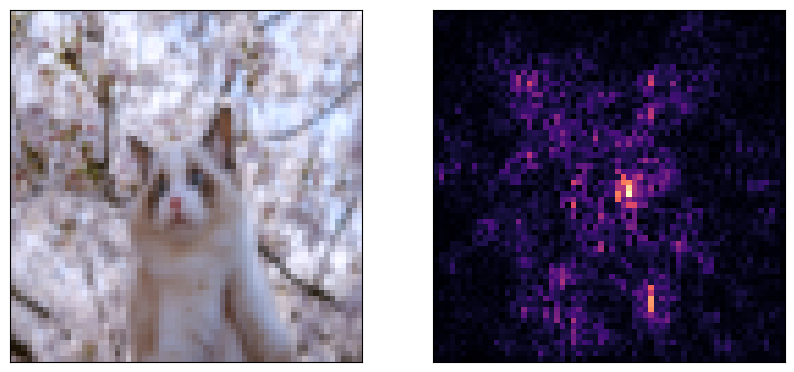

In [28]:

# Load the image
img = Image.open('data/Cat.jpeg').convert('RGB')
saliency(img, model)

Dog


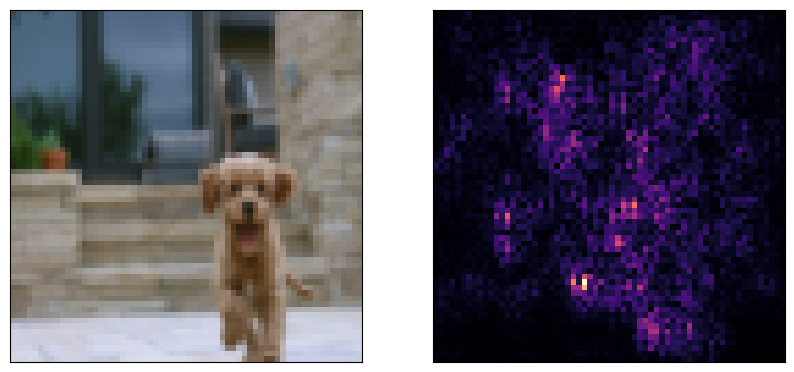

In [29]:
img = Image.open('data/Dog.jpeg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dog


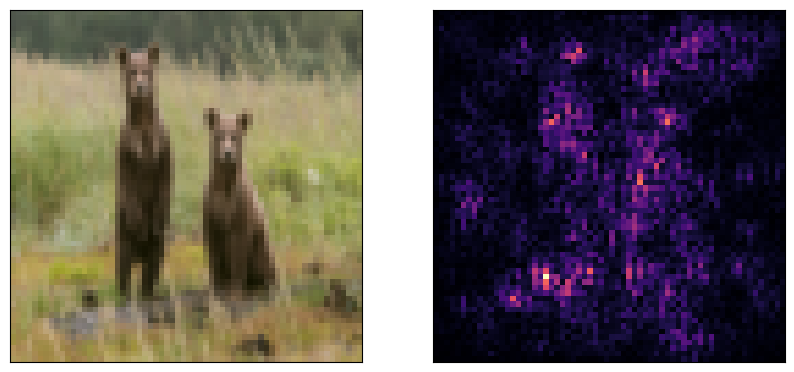

In [31]:
img = Image.open('data/Bear.jpg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dog


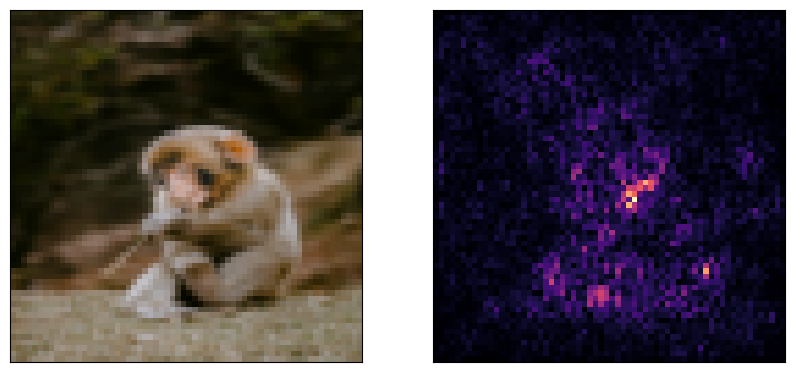

In [32]:
img = Image.open('data/Monkey.jpeg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dog


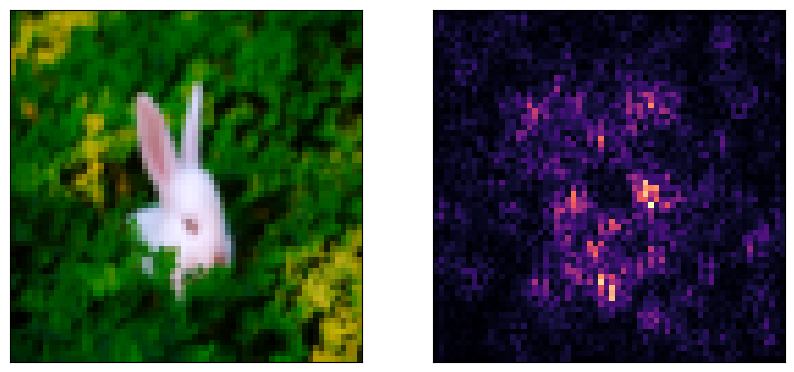

In [33]:
img = Image.open('data/Rabbit.jpeg').convert('RGB')

saliency(img, model)